In [1]:
import numpy as np

import matplotlib.pyplot as plt

In [2]:
import repeated_play

In [3]:
plt.rcParams["font.weight"] = "normal"
plt.rcParams["axes.labelweight"] = "normal"
plt.rcParams["font.size"] = 12

plt.rcParams["font.family"] = "Arial"

In [4]:
import pandas as pd

import matplotlib.patches as mpatches

In [5]:
import sympy as sym

In [6]:
from tqdm.notebook import tqdm

In [7]:
import warnings
warnings.filterwarnings('ignore')

In [8]:
import glob

In [9]:
import itertools

**Helping functions**

In [10]:
def match_payoffs(player, coplayer, Sx, Sy, memory="one"):
    M = repeated_play.transition_matrix_repeated_game(
        player, coplayer, memory=memory
    )

    ss = repeated_play.stationary_distribution(M)[0]

    return ss @ Sx, ss @ Sy

In [11]:
def trnsf_transition_m_memory_two(player, analytical=True):
    
    if analytical == True:
        M = sym.Matrix([[player[0], (1 - player[0]), 0, 0],
                        [0, 0, player[1], (1 - player[1])],
                        [player[2], (1 - player[2]), 0, 0],
                        [0, 0, player[3], (1 - player[3])]])
    else:
        M = np.array([[player[0], (1 - player[0]), 0, 0],
                        [0, 0, player[1], (1 - player[1])],
                        [player[2], (1 - player[2]), 0, 0],
                        [0, 0, player[3], (1 - player[3])]])
    
    
    return M

In [12]:
def match_payoffs_efficiently(player, coplayer, b, c, analytical):

    M = trnsf_transition_m_memory_two(coplayer, analytical=analytical)
    
    if analytical == True:
        ss = repeated_play.stationary_distribution(M, analytical=analytical)
    else:
        ss = repeated_play.stationary_distribution(M)[0]
        
    rho_q = ss[0] + ss[1]
        
    rho_p = sum([ss[i] * p for i, p in enumerate(player)])
    
#     print(rho_q, rho_p)


    payoff_p = (rho_q * b - c * rho_p)
    
    payoff_q = (rho_p * b - c * rho_q)
    
    return payoff_p, payoff_q

In [13]:
def one_bit_condition_one(p1, p2, c, b):
    return p2 < 1 - c / b


def one_bit_condition_two(p1, p2, c, b):
    return p1 > 0.95


def is_partner_one_bit(p1, p2, c, b):
    return (one_bit_condition_one(p1, p2, c, 1)) and (
        one_bit_condition_two(p1, p2, c, 1)
    )

In [14]:
def two_bit_condition_one(p1, p2, p3, p4, c, b):
    return p4 < (1 - c / b)


def two_bit_condition_two(p1, p2, p3, p4, c, b):
    return p2 + p3 < (2 - c / b)


def two_bit_condition_three(p1, p2, p3, p4, c, b):
    return p1 > 0.95


def is_partner_two_bits(p1, p2, p3, p4, c, b):
    return (
        (two_bit_condition_one(p1, p2, p3, p4, c, 1))
        and two_bit_condition_two(p1, p2, p3, p4, c, 1)
        and two_bit_condition_three(p1, p2, p3, p4, c, 1)
    )

In [15]:
def expected_payoffs(payoffRR, payoffRM, payoffMR, payoffMM, N, k):
    
    
    expected_R = ((N - k - 1) / (N - 1)) * payoffRR + (k / (N - 1)) * payoffRM
    
    expected_M = ((N - k) / (N - 1)) * payoffMR + ((k - 1) / (N - 1)) * payoffMM
    
    return expected_R, expected_M

# Data

In [18]:
reactive_abundant = pd.read_csv(
    "../prc_data/evolution_over_seeds_reactive_new.csv", index_col=0
)

## Reactive-1

In [19]:
one_df = reactive_abundant[reactive_abundant['type'] == 'one']

In [20]:
ispartner = []

for i, row in tqdm(one_df.iterrows()):
    condition = is_partner_one_bit(row["p_1"], row["p_2"], 1/2, 1)

    ispartner.append(condition)

0it [00:00, ?it/s]

In [21]:
len(ispartner), len(one_df)

(792110, 792110)

In [22]:
one_df['ispartner'] = ispartner

### Top from cooperative

In [23]:
groups = one_df.groupby('seed')

groups_coop = one_df[(one_df["p_1"] > 0.95)].groupby("seed")
    
top = []

top_coop = []

for i, group in groups:
    top.append(group.sort_values('frequencies').iloc[-1])
    
for i, group in groups_coop:
    top_coop.append(group.sort_values('frequencies').iloc[-1])

In [24]:
top_one_coop = pd.DataFrame(top_coop)

top_one_coop['p_1'] = top_one_coop['p_1'].round(2)

top_one_coop = top_one_coop.sort_values(['p_1', 'p_2'], ascending=False)

### Invaders

In [25]:
invaders = pd.read_csv("../src/evolution_simulations/Invasion/sdim_2_invasions_resident_p_1_q_0.05.csv",
                       header=None, names=["p", "q", "num", "coop"])

In [26]:
invaders1 = pd.read_csv("../src/evolution_simulations/Invasion/sdim_2_invasions_resident_p_1_q_0.49.csv",
                       header=None, names=["p", "q", "num", "coop"])

In [27]:
invaders2 = pd.read_csv("../src/evolution_simulations/Invasion/sdim_2_invasions_resident_p_1_q_0.1.csv",
                       header=None, names=["p", "q", "num", "coop"])

In [28]:
m1, m2, m3 = invaders['num'].mean(), invaders2['num'].mean(), invaders1['num'].mean(),

## Expected payoff

In [29]:
b, c = 1, .5

N = 100

Sx = np.array([b - c, -c, b, 0])

Sy = np.array([b - c, b, -c, 0])

In [30]:
AllD = [0, 0, 0, 0]

resident1 = [1, 0.05] * 2

resident2 = [1, 0.1] * 2

resident3 = [1, 0.49] * 2

In [31]:
pRM1, pMR1 = match_payoffs(resident1, AllD, Sx, Sy, memory="one")

In [32]:
pRM2, pMR2 = match_payoffs(resident2, AllD, Sx, Sy, memory="one")

In [33]:
pRM3, pMR3 = match_payoffs(resident3, AllD, Sx, Sy, memory="one")

In [34]:
pRR1, _ = match_payoffs(resident1, resident1, Sx, Sy, memory="one")

pRR2, _ = match_payoffs(resident2, resident2, Sx, Sy, memory="one")

pRR3, _ = match_payoffs(resident3, resident3, Sx, Sy, memory="one")

In [35]:
pMM, _ =  match_payoffs(AllD, AllD, Sx, Sy, memory="one")

In [36]:
payoffsR = []; payoffsM = []

payoffsR2 = []; payoffsM2 = []

payoffsR3 = []; payoffsM3 = []


for k in range(1, N):

    pR, pM = expected_payoffs(pRR1, pRM1, pMR1, pMM, N, k)

    payoffsR.append(pR)
    payoffsM.append(pM)

    pR2, pM2 = expected_payoffs(pRR2, pRM2, pMR2, pMM, N, k)

    payoffsR2.append(pR2)
    payoffsM2.append(pM2)
    
    
    pR3, pM3 = expected_payoffs(pRR3, pRM3, pMR3, pMM, N, k)

    payoffsR3.append(pR3)
    payoffsM3.append(pM3)

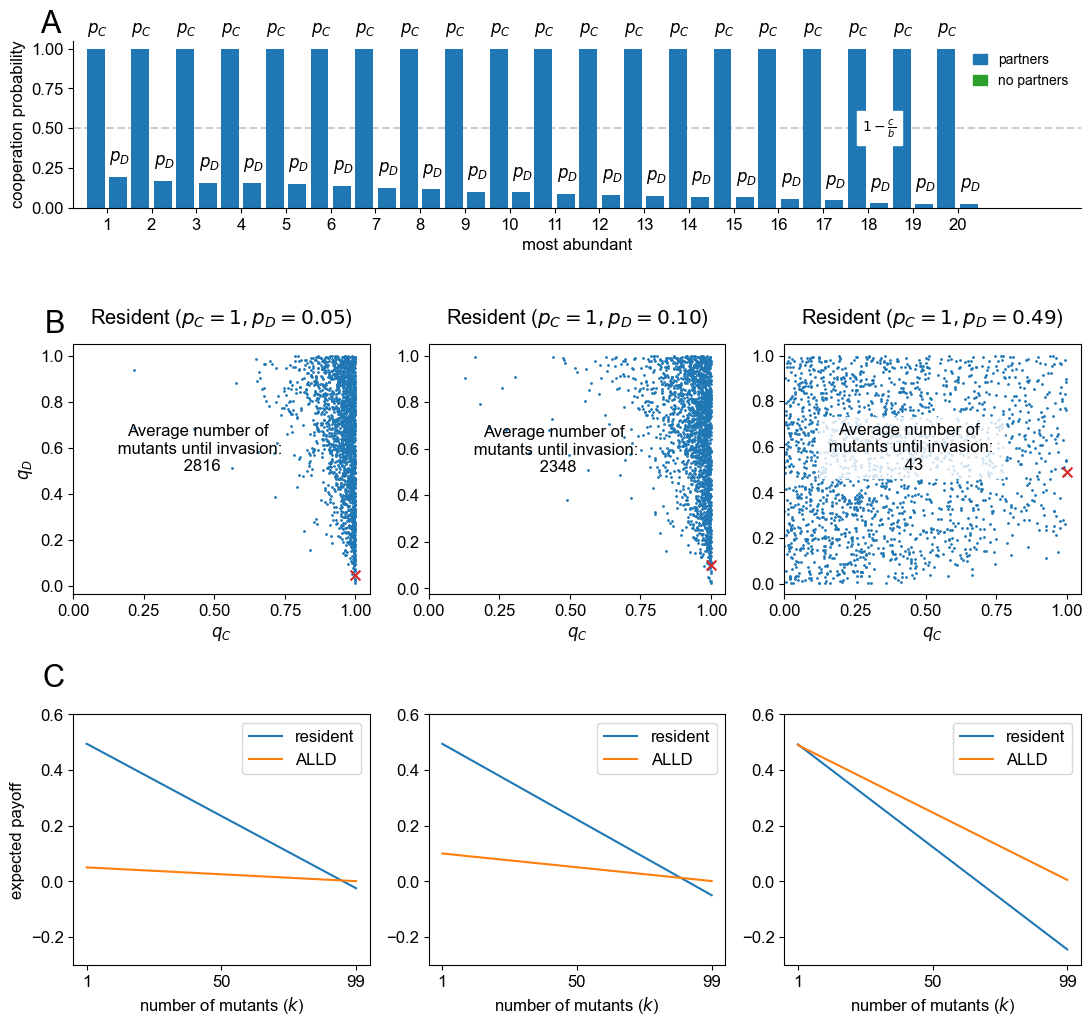

In [38]:
colors = ['tab:blue', 'tab:green']

fig, axes = plt.subplot_mosaic("AAA;...;BCD;...;EFG", figsize=(13, 12),
                               gridspec_kw = {'height_ratios':[1, .2, 1.5,.1, 1.5]})

j = 0

for i, row in top_one_coop.iterrows():
    if row['ispartner'] == True:
        c = colors[0]
    else:
        c = colors[1]
        
    axes["A"].bar([j + 0, j + 1], [row['p_1'], row['p_2']], color=c)
    
    axes["A"].text(j + 0 - .4, row['p_1'] + .1, "$p_{C}$")
    
    axes["A"].text(j + 1 - .4, row['p_2'] + .1, "$p_{D}$")
    
    j += 2
    
axes["A"].axhline(0.5, linestyle='--', color='black', alpha=.2, zorder=-1)

axes["A"].text(35, 0.5, r'$1 - \frac{c}{b}$',
               fontsize=10, va='center', ha='center', backgroundcolor='w');

axes["A"].set_xticks(np.arange(0.5, 40, 2))
axes["A"].set_xticklabels(np.arange(1, 21, 1))
axes["A"].set_xlabel("most abundant")
axes["A"].set_ylabel("cooperation probability")
axes["A"].set_xlim(-1, 44)

label = [
        (
            mpatches.Patch(color='tab:blue'),
            f"partners",
        ),
        (
            mpatches.Patch(color='tab:green'),
            f"no partners",
        )
    ]

axes["A"].legend(
    *zip(*label),
#         bbox_to_anchor=(1.03, 1.01),
    handlelength=1,
    fontsize=10,
    frameon=False,
)

axes["A"].text(-2.5, 1.1, "A", fontsize=22
)


axes["A"].spines[['right', 'top']].set_visible(False)



axes["B"].scatter(invaders["p"], invaders["q"], s=1);
axes["B"].scatter(1, 0.05, s=50, marker='x', color='tab:red');
axes["B"].set_title("Resident ($p_{C} = 1, p_{D} = 0.05$)", y=1.05);
axes["B"].text(0.45, .5,
               f'Average number of \n mutants until invasion: \n {round(m1)}',
               ha='center')


axes["B"].text(-.1, 1.1, "B", fontsize=22
)


axes["C"].scatter(invaders2["p"], invaders2["q"], s=1);
axes["C"].scatter(1, 0.10, s=50, marker='x', color='tab:red');
axes["C"].set_title("Resident ($p_{C} = 1, p_{D} = 0.10$)", y=1.05);
axes["C"].text(0.45, .5,
               f'Average number of \n mutants until invasion: \n {round(m2)}',
               ha='center')

axes["D"].scatter(invaders1["p"], invaders1["q"], s=1);
axes["D"].scatter(1, 0.49, s=50, marker='x', color='tab:red');
axes["D"].set_title("Resident ($p_{C} = 1, p_{D} = 0.49$)", y=1.05);
t = axes["D"].text(0.45, .5,
               f'Average number of \n mutants until invasion: \n {round(m3)}',
               ha='center')
t.set_bbox(dict(facecolor='white', alpha=0.8, edgecolor='white'))


axes["E"].plot(range(1, N), payoffsR, label='resident');
axes["E"].plot(range(1, N), payoffsM, label='ALLD');

axes["E"].text(-15, .7, "C", fontsize=22
)

axes["F"].plot(range(1, N), payoffsR2, label='resident');
axes["F"].plot(range(1, N), payoffsM2, label='ALLD');

axes["G"].plot(range(1, N), payoffsR3, label='resident');
axes["G"].plot(range(1, N), payoffsM3, label='ALLD');

axes["E"].set_ylabel("expected payoff");
axes["B"].set_ylabel("$q_{D}$");

for letter in ["B", "C", "D"]:
    axes[letter].set_xlabel("$q_{C}$");
    axes[letter].set_xlim(0, 1.05)
    

for letter in ["E", "F", "G"]:

    axes[letter].set_xlabel("number of mutants ($k$)");
    axes[letter].set_xticks([1, 50, 99])
    axes[letter].set_ylim(-0.3, 0.6)

    axes[letter].legend();

fig.subplots_adjust(hspace=.36)

fig.savefig("../figures/siFigInvasionR1.pdf", bbox_inches="tight")

# Reactive 2

In [39]:
two_df = reactive_abundant[reactive_abundant['type'] == 'two']

In [40]:
ispartner = []

for i, row in tqdm(two_df.iterrows()):
    condition = is_partner_two_bits(row["p_1"], row["p_2"], row["p_3"], row["p_4"], 1/2, 1)

    ispartner.append(condition)

0it [00:00, ?it/s]

In [41]:
len(ispartner), len(two_df)

(877409, 877409)

In [42]:
two_df['ispartner'] = ispartner

### Top from coop

In [43]:
groups = two_df.groupby('seed')

groups_coop = two_df[(two_df["p_1"] > 0.95)].groupby("seed")
    
top = []

top_coop = []

for i, group in groups:
    top.append(group.sort_values('frequencies').iloc[-1])
    
for i, group in groups_coop:
    top_coop.append(group.sort_values('frequencies').iloc[-1])

In [44]:
top_two = pd.DataFrame(top)

top_two['p_1'] = top_two['p_1'].round(2)

top_two = top_two.sort_values(['p_1', 'p_2', 'p_3', 'p_4'], ascending=False)

top_two = top_two.reset_index(drop=True)

In [45]:
top_two_coop = pd.DataFrame(top_coop)

top_two_coop['p_1'] = top_two_coop['p_1'].round(2)

top_two_coop = top_two_coop.sort_values(['p_1', 'p_2', 'p_3', 'p_4'], ascending=False)

top_two_coop = top_two_coop.reset_index(drop=True)

In [46]:
columns = ["p_cc", 'p_cd', 'p_dc', 'p_dd', 't', 'coop']

invasion = pd.read_csv("../src/evolution_simulations/Invasion/sdim_4_invasions_resident_p1_0.99_p2_0.1_p3_0.6_p4_0.3.csv",
                      names=columns)

invasion2 = pd.read_csv("../src/evolution_simulations/Invasion/sdim_4_invasions_resident_p1_0.99_p2_0.6_p3_0.1_p4_0.3.csv",
                      names=columns)

In [47]:
invasion['t'].mean(), invasion2['t'].mean()

(892.6065393460653, 238.05439456054395)

In [48]:
p_player = [0.99, 0.1, 0.6, 0.3]

p_prime_player = [0.99, 0.6, 0.1, 0.3]

In [49]:
p_player_mem = [p_player[0], p_player[1], p_player[0], p_player[1],
                p_player[2], p_player[3], p_player[2], p_player[3]] * 2


In [50]:
p_prime_player_mem = [p_prime_player[0], p_prime_player[1], p_prime_player[0], p_prime_player[1],
                      p_prime_player[2], p_prime_player[3], p_prime_player[2], p_prime_player[3]] * 2

In [51]:
b, c = 1, .5

N = 100

Sx = np.array([b - c, -c, b, 0] * 4)

Sy = np.array([b - c, b, -c, 0] * 4)

memory = 'two'

In [52]:
match_payoffs(p_player_mem, p_player_mem, Sx, Sy, memory='two')

(0.40050046518990795, 0.40050046518990795)

In [53]:
match_payoffs(p_prime_player_mem, p_prime_player_mem, Sx, Sy, memory='two')

(0.33798502057898233, 0.3379850205789822)

In [54]:
AllD = [0, 0, 0, 0]

resident1 = p_player

resident2 = p_prime_player

In [55]:
pRM1, pMR1 = match_payoffs_efficiently(resident1, AllD, b, c, False)

In [56]:
pRM2, pMR2 = match_payoffs_efficiently(resident2, AllD, b, c, False)

In [57]:
pRR1, _ = match_payoffs_efficiently(resident1, resident1, b, c, False)
pRR2, _ = match_payoffs_efficiently(resident2, resident2, b, c, False)

In [58]:
pMM, _ = match_payoffs_efficiently(AllD, AllD, b, c, False)

In [59]:
pRR1, pRR2

(0.46923076923076923, 0.4125000000000004)

In [60]:
resident1

[0.99, 0.1, 0.6, 0.3]

In [61]:
b, c = 1, .5

N = 100

Sx = np.array([b - c, -c, b, 0])

Sy = np.array([b - c, b, -c, 0])

In [62]:
# match_payoffs(resident1 * 2, resident1 * 2, Sx, Sy, memory=2)

In [63]:
payoffsR = []; payoffsM = []

payoffsR2 = []; payoffsM2 = []


for k in range(1, N):

    pR, pM = expected_payoffs(pRR1, pRM1, pMR1, pMM, N, k)

    payoffsR.append(pR)
    payoffsM.append(pM)

    pR2, pM2 = expected_payoffs(pRR2, pRM2, pMR2, pMM, N, k)

    payoffsR2.append(pR2)
    payoffsM2.append(pM2)

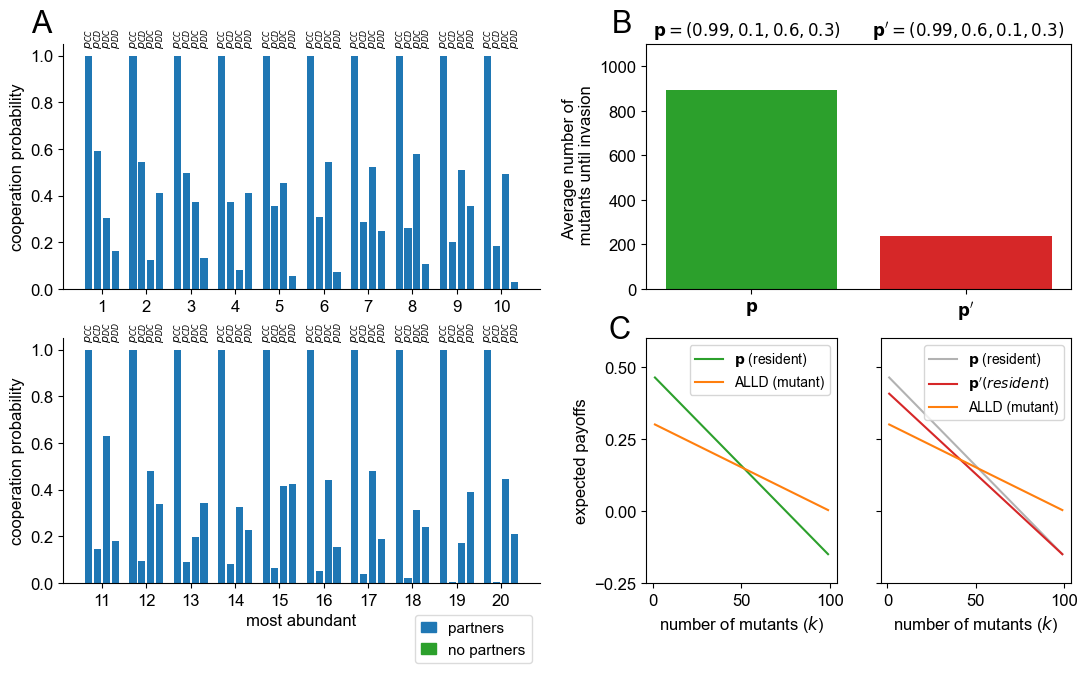

In [61]:
colors = ['tab:blue', 'tab:green']

fig, axes = plt.subplot_mosaic("A.CC;B.DE", figsize=(13, 7), 
                               gridspec_kw = {'width_ratios':[2.5, .1, 1, 1]})


j = 0

for i, row in top_two_coop.iterrows():
    if row['ispartner'] == True:
        c = colors[0]
    else:
        c = colors[1]
        
    if i < 10:
        axes["A"].bar([j + 0, j + 1, j + 2, j + 3],
                      [row['p_1'],
                       row['p_2'],
                       row['p_3'],
                       row['p_4']], color=c)
        
        
        axes["A"].text(j + 0 - .6, row['p_1'] + .05, "$p_{CC}$", fontsize=8, rotation=90)
        axes["A"].text(j + 1 - .6, row['p_1'] + .05, "$p_{CD}$", fontsize=8, rotation=90)
        axes["A"].text(j + 2 - .6, row['p_1'] + .05, "$p_{DC}$", fontsize=8, rotation=90)
        axes["A"].text(j + 3 - .6, row['p_1'] + .05, "$p_{DD}$", fontsize=8, rotation=90)
    
    if i == 10:
        j = 0
    if i >= 10:
        
        axes["B"].bar([j + 0, j + 1, j + 2, j + 3],
                      [row['p_1'], row['p_2'], row['p_3'], row['p_4']], color=c)
        
        axes["B"].text(j + 0 - .6, row['p_1'] + .05, "$p_{CC}$", fontsize=8, rotation=90)
        axes["B"].text(j + 1 - .6, row['p_1'] + .05, "$p_{CD}$", fontsize=8, rotation=90)
        axes["B"].text(j + 2 - .6, row['p_1'] + .05, "$p_{DC}$", fontsize=8, rotation=90)
        axes["B"].text(j + 3 - .6, row['p_1'] + .05, "$p_{DD}$", fontsize=8, rotation=90)
    
    
    j += 5
    
    
axes["A"].text(-6.5, 1.1, "A", fontsize=22
)


axes["A"].spines[['right', 'top']].set_visible(False)
axes["B"].spines[['right', 'top']].set_visible(False)
    
axes["C"].bar([0, 1], [invasion['t'].mean(), invasion2['t'].mean()], color=["tab:green", "tab:red"])
axes["C"].set_ylim(0, 10 ** 3)

axes["C"].set_ylabel("Average number of \n mutants until invasion")
axes["C"].set_xticks([0, 1], labels=[r'$\mathbf{p}$', r"$\mathbf{p'}$"])

axes["D"].plot(range(1, N), payoffsR, label=r'$\mathbf{p}$ (resident)', color='tab:green');
axes["D"].plot(range(1, N), payoffsM, label='ALLD (mutant)', color='tab:orange');

axes["E"].plot(range(1, N), payoffsR, '-', label=r'$\mathbf{p}$ (resident)', color='black', alpha=0.3);

axes["E"].plot(range(1, N), payoffsR2, label=r"$\mathbf{p'} (resident)$", color='tab:red');
axes["E"].plot(range(1, N), payoffsM2, label='ALLD (mutant)', color='tab:orange');

for letter in ["D", "E"]:
    axes[letter].set_ylim(-.15, .6)
    axes[letter].set_xlabel("number of mutants ($k$)")
    axes[letter].legend(fontsize=10, loc = 1);
    

axes["D"].set_yticks([-.25, 0, .25, .5])
axes["E"].set_yticks([-.25, 0, .25, .5], ["" for _ in range(4)])

axes['D'].text(-25, 0.6, "C", fontsize=22)

for letter in ["A", "B"]:
    axes[letter].set_xticks(np.arange(1.5, 50, 5))
    axes[letter].set_ylabel("cooperation probability")
    
axes["D"].set_ylabel("expected payoffs")

axes["A"].set_xticklabels(np.arange(1, 11, 1));
axes["B"].set_xticklabels(np.arange(11, 21, 1));

axes['C'].set_title(r"$\mathbf{p} = (0.99, 0.1, 0.6, 0.3) \qquad \mathbf{p'} = (0.99, 0.6, 0.1, 0.3)$",
                   fontsize=12)

axes['C'].set_ylim(0, 1100)
axes['C'].text(-.65, 1153, "B", fontsize=22)

label = [
        (
            mpatches.Patch(color='tab:blue'),
            f"partners",
        ),
        (
            mpatches.Patch(color='tab:green'),
            f"no partners",
        )
    ]

axes["B"].set_xlabel("most abundant");

axes["B"].legend(
    *zip(*label),
    handlelength=1,
    fontsize=11,
    facecolor='white',
    framealpha=.7,
    ncols=1, bbox_to_anchor=(1, -.1)
    
);


fig.savefig("../figures/siFigInvasionR2.pdf", bbox_inches="tight")

## With $p_{cc} = 1$

In [64]:
p_player = [1, 0.1, 0.6, 0.3]

p_prime_player = [1, 0.6, 0.1, 0.3]

In [65]:
p_player_mem = [p_player[0], p_player[1], p_player[0], p_player[1],
                p_player[2], p_player[3], p_player[2], p_player[3]] * 2


In [66]:
p_prime_player_mem = [p_prime_player[0], p_prime_player[1], p_prime_player[0], p_prime_player[1],
                      p_prime_player[2], p_prime_player[3], p_prime_player[2], p_prime_player[3]] * 2

In [67]:
b, c = 1, .5

N = 100

Sx = np.array([b - c, -c, b, 0] * 4)

Sy = np.array([b - c, b, -c, 0] * 4)

memory = 'two'

In [68]:
match_payoffs(p_player_mem, p_player_mem, Sx, Sy, memory='two')

(0.5, 0.5)

In [69]:
match_payoffs(p_prime_player_mem, p_prime_player_mem, Sx, Sy, memory='two')

(0.5, 0.5)

In [70]:
AllD = [0, 0, 0, 0]

resident1 = p_player

resident2 = p_prime_player

In [71]:
pRM1, pMR1 = match_payoffs_efficiently(resident1, AllD, b, c, False)

In [72]:
pRM2, pMR2 = match_payoffs_efficiently(resident2, AllD, b, c, False)

In [73]:
pRR1, _ = match_payoffs_efficiently(resident1, resident1, b, c, False)
pRR2, _ = match_payoffs_efficiently(resident2, resident2, b, c, False)

In [74]:
pMM, _ = match_payoffs_efficiently(AllD, AllD, b, c, False)

In [75]:
pRR1, pRR2

(0.5, 0.5)

In [76]:
resident1

[1, 0.1, 0.6, 0.3]

In [77]:
b, c = 1, .5

N = 100

Sx = np.array([b - c, -c, b, 0])

Sy = np.array([b - c, b, -c, 0])

In [78]:
# match_payoffs(resident1 * 2, resident1 * 2, Sx, Sy, memory=2)

In [79]:
payoffsR1 = []; payoffsM1 = []

payoffsR21 = []; payoffsM21 = []


for k in range(1, N):

    pR, pM = expected_payoffs(pRR1, pRM1, pMR1, pMM, N, k)

    payoffsR1.append(pR)
    payoffsM1.append(pM)

    pR2, pM2 = expected_payoffs(pRR2, pRM2, pMR2, pMM, N, k)

    payoffsR21.append(pR2)
    payoffsM21.append(pM2)

In [80]:
columns = ["p_cc", 'p_cd', 'p_dc', 'p_dd', 't', 'coop']

invasion1 = pd.read_csv("../src/evolution_simulations/Invasion/sdim_4_invasions_resident_p1_1_p2_0.1_p3_0.6_p4_0.3.csv",
                      names=columns)

invasion21 = pd.read_csv("../src/evolution_simulations/Invasion/sdim_4_invasions_resident_p1_1_p2_0.6_p3_0.1_p4_0.3.csv",
                      names=columns)

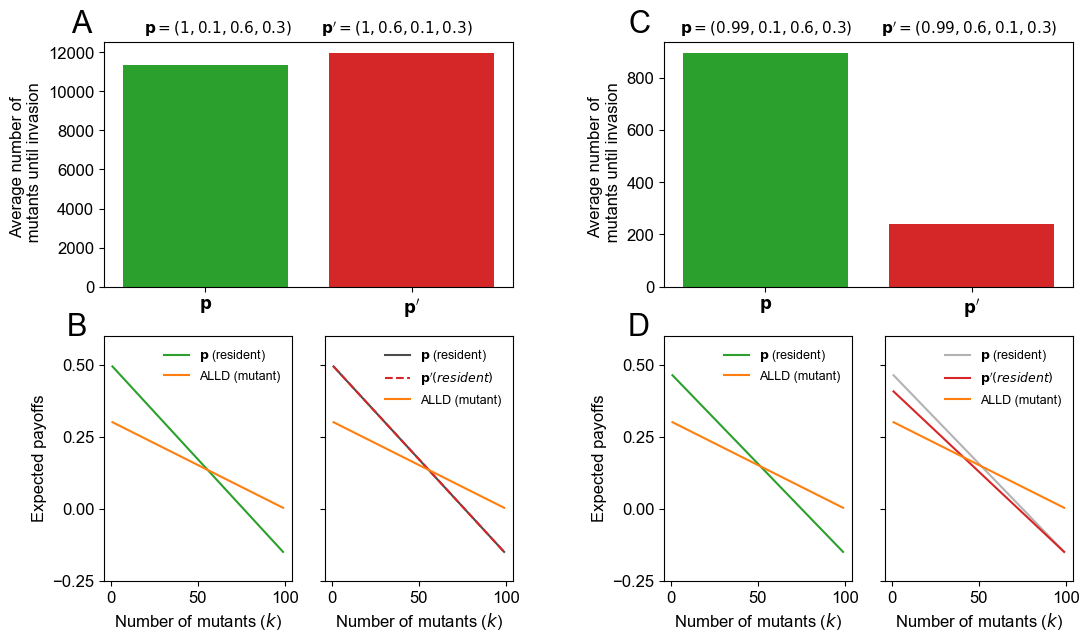

In [132]:
fig, axes = plt.subplot_mosaic("AA.BB;CD.EF", figsize=(12.5, 7), 
                               gridspec_kw = {'width_ratios':[1, 1, .45, 1, 1]})


axes["A"].bar([0, 1],
              [invasion1['t'].mean(), invasion21['t'].mean()], color=["tab:green", "tab:red"]);


axes['A'].set_title(r"$\mathbf{p} = (1, 0.1, 0.6, 0.3) \qquad \mathbf{p'} = (1, 0.6, 0.1, 0.3)$",
                   fontsize=11);

axes["B"].bar([0, 1],
              [invasion['t'].mean(), invasion2['t'].mean()], color=["tab:green", "tab:red"]);

axes['B'].set_title(r"$\mathbf{p} = (0.99, 0.1, 0.6, 0.3) \qquad \mathbf{p'} = (0.99, 0.6, 0.1, 0.3)$",
                   fontsize=11)

for letter in ["A", "B"]:
    axes[letter].set_ylabel("Average number of \n mutants until invasion")
    axes[letter].set_xticks([0, 1], labels=[r'$\mathbf{p}$', r"$\mathbf{p'}$"]);


axes["C"].plot(range(1, N), payoffsR1, label=r'$\mathbf{p}$ (resident)', color='tab:green');
axes["C"].plot(range(1, N), payoffsM1, label='ALLD (mutant)', color='tab:orange');

axes["D"].plot(range(1, N), payoffsR1, '-', label=r'$\mathbf{p}$ (resident)', color='black', alpha=0.7);

axes["D"].plot(range(1, N), payoffsR21, '--', label=r"$\mathbf{p'} (resident)$", color='tab:red');
axes["D"].plot(range(1, N), payoffsM21, label='ALLD (mutant)', color='tab:orange');


axes["E"].plot(range(1, N), payoffsR, label=r'$\mathbf{p}$ (resident)', color='tab:green');
axes["E"].plot(range(1, N), payoffsM, label='ALLD (mutant)', color='tab:orange');

axes["F"].plot(range(1, N), payoffsR, '-', label=r'$\mathbf{p}$ (resident)', color='black', alpha=0.3);

axes["F"].plot(range(1, N), payoffsR2, label=r"$\mathbf{p'} (resident)$", color='tab:red');
axes["F"].plot(range(1, N), payoffsM2, label='ALLD (mutant)', color='tab:orange');

for letter in ["C", "D", "E", "F"]:
    axes[letter].set_ylim(-.15, .6)
    axes[letter].set_xlabel("Number of mutants ($k$)")
    axes[letter].legend(fontsize=9, loc = 1, frameon=False);
    
for letter in ["C", "E"]:
    axes[letter].set_yticks([-.25, 0, .25, .5])
    axes[letter].set_ylabel("Expected payoffs")
    
for letter in ['D', 'F']:
    axes[letter].set_yticks([-.25, 0, .25, .5],
                            ["" for _ in range(4)]);
    
    
axes['A'].text(-.65, 13000, "A", fontsize=22);
axes['A'].text(2.05, 13000, "C", fontsize=22);

axes['C'].text(-25, 0.6, "B", fontsize=22);
axes['E'].text(-25, 0.6, "D", fontsize=22);



fig.savefig("../figures/siFigInvasionR2.pdf", bbox_inches="tight")

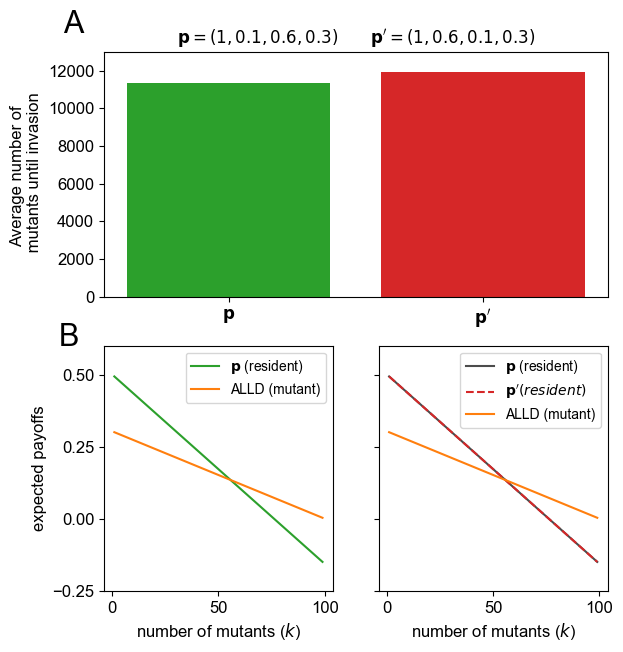

In [151]:
fig, axes = plt.subplot_mosaic("CC;AB", figsize=(6.5, 7), 
                               gridspec_kw = {'width_ratios':[1, 1]})

axes["C"].bar([0, 1], [invasion['t'].mean(), invasion2['t'].mean()], color=["tab:green", "tab:red"]);


axes["A"].plot(range(1, N), payoffsR, label=r'$\mathbf{p}$ (resident)', color='tab:green');
axes["A"].plot(range(1, N), payoffsM, label='ALLD (mutant)', color='tab:orange');

axes["B"].plot(range(1, N), payoffsR, '-', label=r'$\mathbf{p}$ (resident)', color='black', alpha=0.7);

axes["B"].plot(range(1, N), payoffsR2, '--', label=r"$\mathbf{p'} (resident)$", color='tab:red');
axes["B"].plot(range(1, N), payoffsM2, label='ALLD (mutant)', color='tab:orange');


for letter in ["A", "B"]:
    axes[letter].set_ylim(-.15, .6)
    axes[letter].set_xlabel("number of mutants ($k$)")
    axes[letter].legend(fontsize=10, loc = 1);
    

axes["A"].set_yticks([-.25, 0, .25, .5])
axes["B"].set_yticks([-.25, 0, .25, .5], ["" for _ in range(4)]);
    
axes["A"].set_ylabel("expected payoffs")


axes['C'].set_title(r"$\mathbf{p} = (1, 0.1, 0.6, 0.3) \qquad \mathbf{p'} = (1, 0.6, 0.1, 0.3)$",
                   fontsize=12);


axes["C"].set_ylim(0, 13000);

axes["C"].set_ylabel("Average number of \n mutants until invasion")
axes["C"].set_xticks([0, 1], labels=[r'$\mathbf{p}$', r"$\mathbf{p'}$"]);


axes['C'].text(-.65, 14000, "A", fontsize=22)
axes['A'].text(-25, 0.6, "B", fontsize=22)

fig.savefig("../figures/siFigInvasionR2ForPCCone.pdf", bbox_inches="tight")